In [135]:
# https://data-analysis-stats.jp/%E6%B7%B1%E5%B1%9E%E5%AD%A6%E7%BF%92/keras-autoencoder-%E3%81%A7%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%E3%80%8C%E8%A9%90%E6%AC%BA%E6%A4%9C%E7%9F%A5%E3%80%8D/
# https://qiita.com/tk-tatsuro/items/10e9dbb3f2cf030e2119
!pip install lightGBM==4.3.0
!pip list | grep lightgbm

lightgbm                      4.3.0


In [136]:
import pandas as pd
import seaborn as sns

import numpy as np
# CSVファイルを読み込む
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
genre_data = pd.read_csv('input/genre_labels.csv')
print("train_data;",len(train))
print("test_data;",len(test))

train_data; 4046
test_data; 4046


In [137]:
# データの可視化
train.describe()

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness
count,4046.000000,4046.000000,4046.000000,4.046000e+03,4046.000000,4036.000000,4038.000000,4046.000000,4046.000000,4043.000000,4038.000000,4045.000000
mean,2022.500000,7.281760,41.056105,2.421410e+05,0.346455,0.464100,0.504347,-7.715659,0.603663,0.265986,0.198655,0.214336
std,1168.123923,2.887542,16.165708,8.520241e+04,0.241004,0.225052,0.158415,4.109640,0.201020,0.155769,0.083557,0.154281
min,0.000000,0.000000,0.000000,5.998000e+03,0.000000,0.000000,0.013839,-37.820457,0.003383,0.000000,0.000000,0.000000
25%,1011.250000,7.000000,31.000000,2.044420e+05,0.149705,0.276384,0.392581,-9.775363,0.462137,0.168527,0.148698,0.143295
50%,2022.500000,8.000000,42.000000,2.358735e+05,0.250711,0.450211,0.510993,-7.189460,0.634078,0.218486,0.183190,0.171708
75%,3033.750000,10.000000,52.000000,2.724020e+05,0.523088,0.644786,0.617371,-4.876553,0.768768,0.317773,0.224999,0.205446
max,4045.000000,10.000000,82.000000,2.135773e+06,1.000000,0.989661,1.000000,0.000000,1.000000,1.000000,0.886806,1.000000


In [138]:
train.isnull().sum()

# Nullを埋め込み（testデータは何かしらで補完しないといけないのでtrainも同様に補完する）



index                0
genre                0
popularity           0
duration_ms          0
acousticness         0
positiveness        10
danceability         8
loudness             0
energy               0
liveness             3
speechiness          8
instrumentalness     1
tempo                0
region               0
dtype: int64

In [139]:
# とりあえず線形補完。上端はそのままになるので注意
# train.replace(['NaN', 'None', ''], float('nan'))
train = train.interpolate()

In [140]:
test.describe()

,index,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness
count,4046.000000,4046.000000,4.046000e+03,4045.000000,4032.000000,4035.000000,4046.000000,4045.000000,4040.000000,4035.000000,4044.000000
mean,6068.500000,41.158181,2.418486e+05,0.335216,0.467855,0.499143,-7.636531,0.608755,0.268926,0.201776,0.216227
std,1168.123923,16.107248,7.829733e+04,0.236284,0.220606,0.161413,3.989469,0.200665,0.157032,0.086553,0.156315
min,4046.000000,0.000000,5.826000e+03,0.012727,0.014537,0.000000,-30.216122,0.000000,0.017454,0.016510,0.045321
25%,5057.250000,31.000000,2.019200e+05,0.145535,0.288579,0.388765,-9.768664,0.461840,0.168854,0.149764,0.144141
50%,6068.500000,42.000000,2.353070e+05,0.245121,0.446927,0.508350,-7.088928,0.636469,0.220989,0.186697,0.172429
75%,7079.750000,52.000000,2.724925e+05,0.494312,0.641742,0.616642,-4.936082,0.774140,0.323248,0.229745,0.205682
max,8091.000000,82.000000,1.105001e+06,0.985922,1.000000,0.948866,0.000000,0.991536,0.997364,1.000000,0.927823


In [141]:
test.isnull().sum()

index                0
popularity           0
duration_ms          0
acousticness         1
positiveness        14
danceability        11
loudness             0
energy               1
liveness             6
speechiness         11
instrumentalness     2
tempo                0
region               0
dtype: int64

In [142]:
# とりあえず線形補完。上端はそのままになるので注意
test = test.interpolate()


In [143]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4046 non-null   int64  
 1   genre             4046 non-null   int64  
 2   popularity        4046 non-null   int64  
 3   duration_ms       4046 non-null   int64  
 4   acousticness      4046 non-null   float64
 5   positiveness      4046 non-null   float64
 6   danceability      4046 non-null   float64
 7   loudness          4046 non-null   float64
 8   energy            4046 non-null   float64
 9   liveness          4046 non-null   float64
 10  speechiness       4046 non-null   float64
 11  instrumentalness  4046 non-null   float64
 12  tempo             4046 non-null   object 
 13  region            4046 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 442.7+ KB


In [144]:
# カテゴリ変数と質量変数に分類(genreは目的変数なので対象外)
categorical = ["region"]
target_col = ["genre"]
genre_data


,genre,labels
0,country,0
1,electronic,1
2,folk,2
3,hip-hop,3
4,jazz,4
5,latin,5
6,classic,6
7,other-light-music,7
8,pop,8
9,religious,9


Text(0, 0.5, 'Frequency')

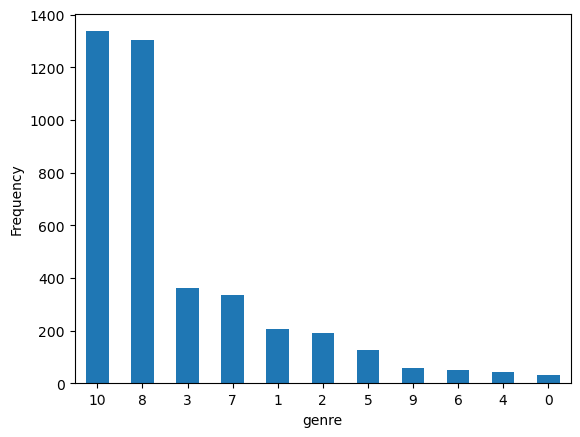

In [145]:
# 正常データと異常データの頻度を確認
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 10

count_classes = pd.value_counts(train['genre'], sort = True)
count_classes.plot(kind = 'bar', rot=1)
plt.xlabel("genre")
plt.ylabel("Frequency")


Text(0, 0.5, 'Frequency')

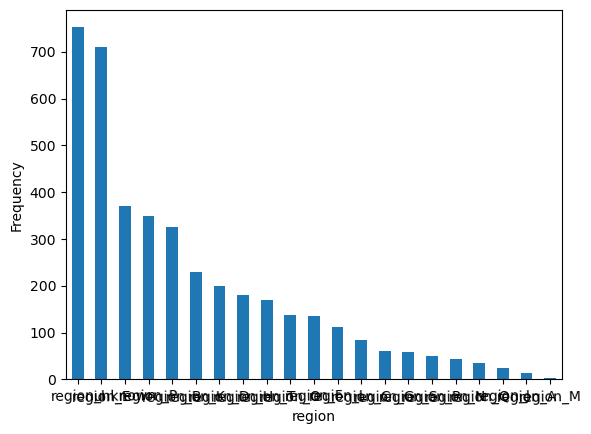

In [146]:
# 正常データと異常データの頻度を確認
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 10

count_classes = pd.value_counts(train['region'], sort = True)
count_classes.plot(kind = 'bar', rot=1)
plt.xlabel("region")
plt.ylabel("Frequency")


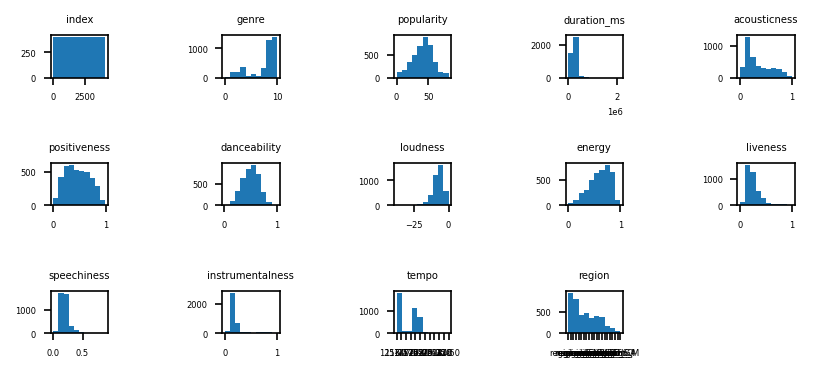

In [147]:
fig = plt.figure(dpi=150)
for i, col in enumerate(train.columns):
    plt.rcParams["font.size"] = 4
    plt.subplots_adjust(wspace=2, hspace=2)
    # plt.figure(figsize=(4, 4))
    plt.subplot2grid((5, 5), (i//5 ,i%5))
    plt.hist(train[col])
    plt.title(col)


In [148]:
train.columns

Index(['index', 'genre', 'popularity', 'duration_ms', 'acousticness',
       'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
       'speechiness', 'instrumentalness', 'tempo', 'region'],
      dtype='object')

In [149]:
exec_flag=False
#　処理に時間がかかるので見たい時だけTrueにしてください
if exec_flag:
    sns.pairplot(data=train[["genre","popularity", "duration_ms", "acousticness", "positiveness", "danceability", "loudness",
                              "energy", "liveness", "speechiness", "instrumentalness", "tempo", "region"]], hue="genre", dropna=True)

In [150]:
# tempoとregionをintに変換する。
# from sklearn.preprocessing import LabelEncoder
label = ["region","tempo"]
for col in label:
    encoder = {c: i for i, c in enumerate(train[col].unique())}
    train[f'label_{col}'] = train[col].map(encoder)
    test[f'label_{col}'] = test[col].map(encoder)



In [151]:
# tempoはtempoの幅を新たな特長量として取得する。
train_tempo_low = train["tempo"].str.extract('(.+)-', expand=True)
train_tempo_high = train["tempo"].str.extract('-(.+)', expand=True)

test_tempo_low = test["tempo"].str.extract('(.+)-', expand=True)
test_tempo_high = test["tempo"].str.extract('-(.+)', expand=True)


In [152]:
train_tempo_low = train_tempo_low.astype(int)
train_tempo_high = train_tempo_high.astype(int)
train["tempo_range"] = train_tempo_high[0] - train_tempo_low[0]
train["tempo_low"] = train_tempo_low
train["tempo_high"] = train_tempo_high
train.describe()

test_tempo_low = test_tempo_low.astype(int)
test_tempo_high = test_tempo_high.astype(int)
test["tempo_range"] = test_tempo_high[0] - test_tempo_low[0]
test["tempo_low"] = test_tempo_low
test["tempo_high"] = test_tempo_high
test.describe()

,index,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,label_region,label_tempo,tempo_range,tempo_low,tempo_high
count,4046.000000,4046.000000,4.046000e+03,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000,4046.000000
mean,6068.500000,41.158181,2.418486e+05,0.335188,0.467623,0.498999,-7.636531,0.608751,0.268862,0.201718,0.216203,5.898913,2.439446,24.207612,109.867029,134.074642
std,1168.123923,16.107248,7.829733e+04,0.236261,0.220419,0.161353,3.989469,0.200640,0.156928,0.086481,0.156280,4.900333,2.142089,5.719993,29.073576,31.155091
min,4046.000000,0.000000,5.826000e+03,0.012727,0.014537,0.000000,-30.216122,0.000000,0.017454,0.016510,0.045321,0.000000,0.000000,5.000000,0.000000,40.000000
25%,5057.250000,31.000000,2.019200e+05,0.145570,0.288486,0.388701,-9.768664,0.461895,0.168966,0.149790,0.144164,1.000000,0.000000,19.000000,97.000000,120.000000
50%,6068.500000,42.000000,2.353070e+05,0.245119,0.446824,0.508093,-7.088928,0.636347,0.220989,0.186697,0.172419,4.000000,3.000000,23.000000,97.000000,120.000000
75%,7079.750000,52.000000,2.724925e+05,0.494206,0.641574,0.616498,-4.936082,0.774118,0.323119,0.229689,0.205666,10.000000,4.000000,31.000000,121.000000,152.000000
max,8091.000000,82.000000,1.105001e+06,0.985922,1.000000,0.948866,0.000000,0.991536,0.997364,1.000000,0.927823,19.000000,11.000000,40.000000,209.000000,220.000000


In [153]:
# regionは変換完了したのでlabelは削除する
train.drop(["region","tempo"], axis=1, inplace=True)
test.drop(["region","tempo"], axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4046 non-null   int64  
 1   genre             4046 non-null   int64  
 2   popularity        4046 non-null   int64  
 3   duration_ms       4046 non-null   int64  
 4   acousticness      4046 non-null   float64
 5   positiveness      4046 non-null   float64
 6   danceability      4046 non-null   float64
 7   loudness          4046 non-null   float64
 8   energy            4046 non-null   float64
 9   liveness          4046 non-null   float64
 10  speechiness       4046 non-null   float64
 11  instrumentalness  4046 non-null   float64
 12  label_region      4046 non-null   int64  
 13  label_tempo       4046 non-null   int64  
 14  tempo_range       4046 non-null   int64  
 15  tempo_low         4046 non-null   int64  
 16  tempo_high        4046 non-null   int64  


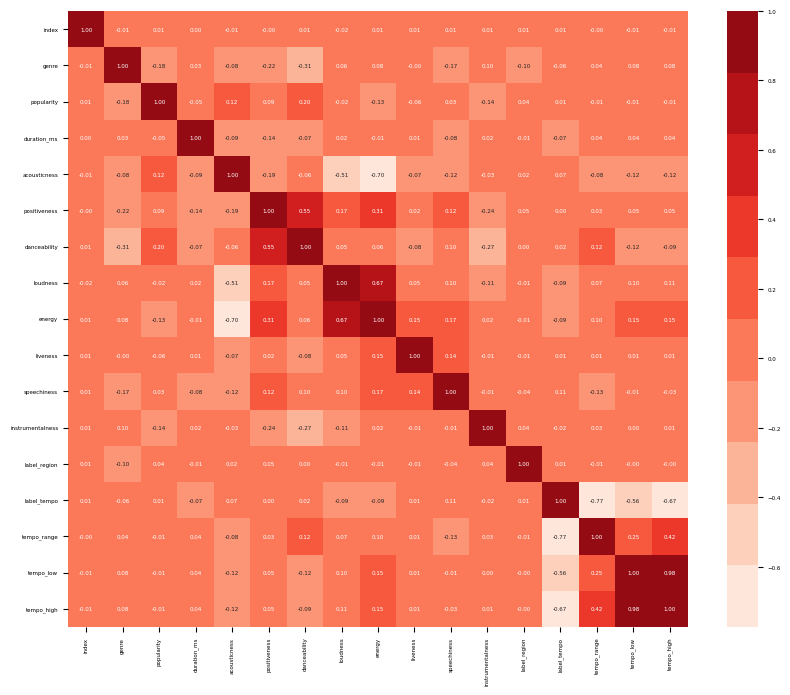

In [154]:
# 情報量が多く処理が完了しないので8月までのデータでヒートマップ算出する
%matplotlib inline
corrs = np.corrcoef(train, rowvar=False)
fig,ax = plt.subplots(figsize=(10,8))

sns.heatmap(corrs, cmap=sns.color_palette('Reds', 10), annot=True,
            fmt='.2f', xticklabels=train.columns.tolist(), yticklabels=train.columns.tolist())
# input_features = ["x_customer_id","y_customer_id","x_terminal_id","y_terminal_id","distance",'TX_AMOUNT',"TX_AMOUNT-mean","mean_amount","std_amount","mean_nb_tx_per_day"]
# sns.heatmap(train_total[input_features],vmax=1, vmin=-1, center=0)
plt.savefig("heatmap.png")

In [155]:
# 対数変換
# log_list = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium"]
# fig = plt.figure(dpi=150)
# for i,indent in enumerate(log_list):
#     plt.rcParams["font.size"] = 4
#     plt.subplots_adjust(wspace=2, hspace=2)
#     train[indent] = np.log(train[indent])
#     test[indent] = np.log(test[indent])
#     plt.subplot2grid((5, 5), (i//5 ,i%5))
#     plt.hist(train[indent])
#     plt.title(indent)
# train.describe()

In [156]:
##特徴選択
!pip install imblearn

In [157]:
# # ②不均衡データへの処置
# # アンダーサンプリング
# from imblearn.under_sampling import RandomUnderSampler

# target = 'target'
# rs = RandomUnderSampler(random_state=42)
# under_sampling ,_ = rs.fit_resample(train, train[target])

# print('*'*20)
# print('＜元のデータ＞')
# print('0の件数：%d'%len(train.query(f'{target}==0')))
# print('1の件数：%d'%len(train.query(f'{target}==1')))
# print('*'*20)
# print('＜アンダーサンプリング後のデータ＞')
# print('0の件数：%d'%len(under_sampling.query(f'{target}==0')))
# print('1の件数：%d'%len(under_sampling.query(f'{target}==1')));

# train = under_sampling.copy()


In [158]:
# 学習データと結果に分割
# 正常データを異常データと同数にして学習
# train_total = under_sampling.copy()
y = train['genre']
train.drop('genre', axis=1, inplace=True)
# idは削除
train.drop('index', axis=1, inplace=True)
#多重共線性の観点から位置を省いてみる
# train_total = train.drop(['x_customer_id',"y_customer_id"], axis=1) #'count' 列を削除

test_id = test["index"]
test.drop('index', axis=1, inplace=True)
test_total = test.copy()
# test_total = test.drop(['x_customer_id',"y_customer_id"], axis=1) #'count' 列を削除


In [159]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def calc_accuracy(y_pred, y_true):
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True

def calc_precision(y_pred, y_true):
    metric = precision_score(y_true, y_pred)
    return 'precison', metric, True

def calc_recall(y_pred, y_true):
    metric = recall_score(y_true, y_pred)
    return 'recall', metric, True

def calc_fscore(fscores):
    metric = np.max(fscores)
    return 'fscore', metric, True

def calc_auc(y_pred, y_true):
    metric = roc_auc_score(y_true, y_pred)
    return 'auc', metric, True

def calc_prauc(y_pred, y_true):
    metric = average_precision_score(y_true, y_pred)
    return 'prauc', metric, True

In [160]:
def acquire_custom_metircs(preds ,data):
    # precisions, recalls, thresholds = precision_recall_curve(data.get_label(), preds, pos_label=1)
    # thresholds = np.append(thresholds, 1)
    # fscores = 2 * precisions * recalls / (precisions + recalls)
    # threshold_max_fscore = thresholds[np.argmax(fscores)]

    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)

    # return [
    #     calc_accuracy(y_pred, y_true),  ＃ Accuracy
    #     calc_precision(y_pred, y_true),  ＃ Precision
    #     calc_recall(y_pred, y_true),  # Recall
    #     calc_fscore(fscores),  # F1 score
    #     calc_auc(y_pred, y_true),  # ROC AUC
    #     calc_prauc(y_pred, y_true)  # PR AUC
    # ]
    score = calc_precision(y_pred, y_true), # Precision 
    # print("precision")
    # print(score[0])
    return score[0]

In [161]:
#量的変数の定義
# agg_cols = ['min', 'max', 'mean', 'std']
# カテゴリカル変数の定義
# cat_cols = ['anaemia', 'dカテゴリカルiabetes', 'high_blood_pressure','sex',"smoking"]

In [162]:
# カテゴリカル変数と量的変数を組み合わせて新たな特長量を生成する。今回はカテゴリカル変数は少ないので省略

# for col in cat_cols:
#     grp_df = train.groupby(col)[log_list].agg(agg_cols)
#     grp_df.columns = [f'{col}_' + '_'.join(c) for c in grp_df.columns]
#     train = train.merge(grp_df, on=col, how='left')
#     test_total = test_total.merge(grp_df, on=col, how='left')    

In [163]:
!pip install -U "setuptools<58"
!pip install xfeat

In [164]:
# カテゴリ変数の組み合わせで新たな特長量を生成する。今回はカテゴリかる変数が少ないのでコメントアウト

# import xfeat

# for i in [2, 3]:
#     print(i)
#     concat = xfeat.ConcatCombination(r=i, drop_origin=True)
#     train = pd.concat([train, concat.fit_transform(train[cat_cols])], axis=1)
#     test_total = pd.concat([test_total, concat.fit_transform(test[cat_cols])], axis=1)

In [165]:
# 対数変換データの標準化？
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(train[log_list])
# train[log_list] = scaler.transform(train[log_list])
# test_total[log_list] = scaler.transform(test_total[log_list])

In [166]:
print(train.columns)
# 学習データと検証データの分割
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.3, random_state=42)
train.info()

Index(['popularity', 'duration_ms', 'acousticness', 'positiveness',
       'danceability', 'loudness', 'energy', 'liveness', 'speechiness',
       'instrumentalness', 'label_region', 'label_tempo', 'tempo_range',
       'tempo_low', 'tempo_high'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        4046 non-null   int64  
 1   duration_ms       4046 non-null   int64  
 2   acousticness      4046 non-null   float64
 3   positiveness      4046 non-null   float64
 4   danceability      4046 non-null   float64
 5   loudness          4046 non-null   float64
 6   energy            4046 non-null   float64
 7   liveness          4046 non-null   float64
 8   speechiness       4046 non-null   float64
 9   instrumentalness  4046 non-null   float64
 10  label_region      4046 non-null   int64  
 11  label_t

In [167]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
#条件設定
max_score = 0
SearchMethod = 0
RFC_grid = {RandomForestClassifier(): {"n_estimators":[i for i in range(1, 100,10)],
                                       "criterion": ["entropy"],
                                       "max_depth":[15,20,25],
                                       "min_samples_split":[1,3],
                                       "min_samples_leaf":[1,3, 5],
                                      }}
# RFC_grid = {RandomForestClassifier(): {"n_estimators": [i for i in range(1, 21)],
#                                        "criterion": ["gini", "entropy"],
#                                        "max_depth":[i for i in range(1, 5)],
#                                        "random_state": [i for i in range(0, 101)]
#                                       }}
#ランダムフォレストの実行
for model, param in tqdm(RFC_grid.items()):
    clf = GridSearchCV(model, param)
    clf.fit(X_train, y_train)
    y_pred_train_rf = clf.predict(X_valid)
    score = f1_score(y_valid, y_pred_train_rf, average="micro")

    if max_score < score:
        max_score = score
        best_param = clf.best_params_
        best_model = model.__class__.__name__

print("ベストスコア:{}".format(max_score))
print("モデル:{}".format(best_model))
print("パラメーター:{}".format(best_param))

  0%|          | 0/1 [00:00<?, ?it/s]/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
450 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/skl

ベストスコア:0.5815485996705108
モデル:RandomForestClassifier
パラメーター:{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 91}


In [168]:
genre_data["genre"]

0               country
1            electronic
2                  folk
3               hip-hop
4                  jazz
5                 latin
6               classic
7     other-light-music
8                   pop
9             religious
10                 rock
Name: genre, dtype: object

f1_score=0.5815485996705108


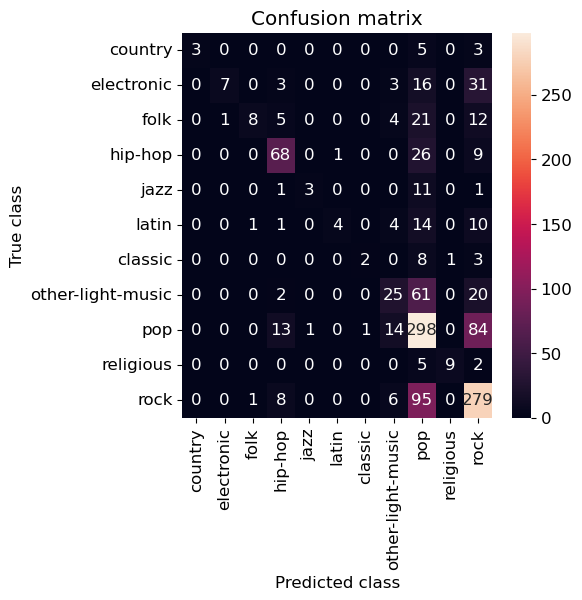

In [169]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "RandomForest"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train_rf > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train_rf.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")

print(f'f1_score={f1_score}')
plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


In [170]:
# lghtGBMのグリッドサーチ
## それぞれのハイパラをサーチすることでひとまずパラメータの当たり付けを行う。

In [171]:
# ## グリッドサーチ
# import lightgbm as lgb

# # https://pythonandai.com/grid-search/
# from sklearn.model_selection import GridSearchCV
# learning_rate = [0.001]
# num_leaves = [31]
# max_depth = [12]
# min_data_in_leaf = [20]
# params = {
#     'boosting_type': ['gbdt'],
#     'objective': ['binary'],
#     # 'metric': 'rmse',
#     'metric': ['binary_logloss',"auc"],
#     # 'metric': 'auc', # AUCでもいい
    
#     # "seed":[31],
#     # 'random_state': [42],
#     # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # 'verbose' : [-1],
#     "num_iterations":[10000], # early stopping で止まるため大きめに設定しておけばよい
    
#     # 以下のパラメータを調整対象とする
#     "learning_rate": learning_rate, #学習率
#     "num_leaves":num_leaves,
#     "max_depth":max_depth,
#     "min_data_in_leaf":min_data_in_leaf,
#     # "bagging_fraction":[0.8],
#     # "bagging_freq":[1],
# }

# lgbm = lgb.LGBMClassifier(random_state=0)
# gcv = GridSearchCV(lgbm, params, cv=3, scoring='precision', return_train_score=True)
# gcv.fit(X_train, y_train)

In [172]:
# # グリッドサーチの結果から、学習データとテストデータのスコアを取得
# train_score = gcv.cv_results_["mean_train_score"]
# test_score = gcv.cv_results_["mean_test_score"]

# # matplotlib.pyplotを省略名pltとしてインポート 
# import matplotlib.pyplot as plt
# plt.rcParams["font.size"] = 14

# # 学習データのスコアをプロット
# plt.plot(num_leaves, train_score, label="train_score")

# # テストデータのスコアをプロット
# plt.plot(num_leaves, test_score, label="test_score")

# # グラフにタイトルを追加
# plt.title('train_score vs test_score')

# # グラフのx軸に名前を追加
# plt.xlabel('learning_rate')

# # グラフのy軸に名前を追加
# plt.ylabel('precision')

# # 凡例の表示
# plt.legend()

# # グラフの表示
# plt.show()

In [173]:
# # グリッドサーチの結果から、最適なパラメータを表示
# print("Best parameters: ", gcv.best_params_)

# # 最適なパラメータで学習したモデルを取得
# optimal_model = gcv.best_estimator_

# # 最適なモデルを用いて、評価用データの予測を行う
# predicted_values = optimal_model.predict_proba(test_total)[:,1]


In [174]:
# lghtGBMのグリッドサーチ
## それぞれのハイパラをサーチすることでひとまずパラメータの当たり付けを行う。

# finish

In [175]:
# 上の方法だとうまく重みづけ学習できないので、別ページを参考に実践する
# https://an-engineer-note.com/?p=312#toc3
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
# dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？

In [176]:
learning_rate = 0.001
num_leaves = 31
max_depth = 15
min_data_in_leaf = 20
metric = "multi_logloss"
params = {
    'boosting_type': 'gbdt',
    'num_class': 11, # クラスの数
    'objective': 'multiclass',
    'metric': metric,
    # 'metric': 'binary_logloss',
    # 'metric': 'auc', # AUCでもいい
    
    # "seed":31,
    # 'random_state': 42,
    # 'lambda_l2':1, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    "bagging_fraction":0.9,
    "bagging_freq":5,
    "feature_fraction":0.7,
}

In [177]:

#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 10000,
               #   categorical_feature = cat_cols, #ここでcategorical_featureを設定
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=200, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2442
[LightGBM] [Info] Number of data points in the train set: 2832, number of used features: 15
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -4.904216
[LightGBM] [Info] Start training from score -2.972005
[LightGBM] [Info] Start training from score -3.007096
[LightGBM] [Info] Start training from score -2.395779
[LightGBM] [Info] Start training from scor

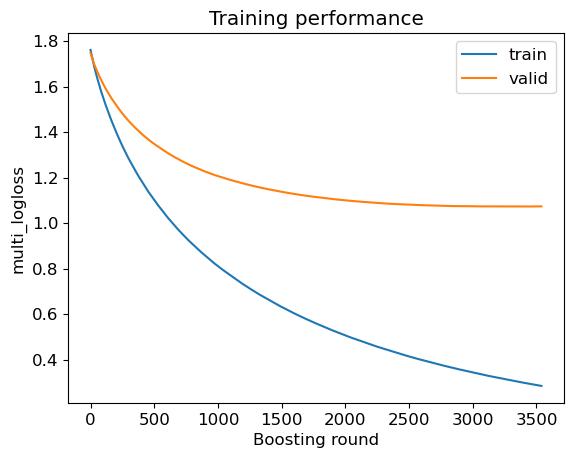

In [178]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train'][metric], label='train')
plt.plot(evaluation_results['valid'][metric], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [179]:
y_pred = gbm.predict(test_total)

In [181]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

         0         1         2         3         4         5         6   \
0  0.000707  0.031169  0.024928  0.086539  0.000898  0.061354  0.001233   
1  0.000481  0.381802  0.007422  0.009157  0.000591  0.010675  0.002797   
2  0.000266  0.002711  0.009659  0.001217  0.000084  0.000488  0.000200   
3  0.000332  0.006197  0.005125  0.833053  0.000359  0.010133  0.000453   
4  0.000472  0.019544  0.073770  0.030591  0.000878  0.011070  0.002544   

         7         8         9         10  
0  0.045768  0.316156  0.001325  0.429922  
1  0.084946  0.234475  0.001015  0.266640  
2  0.001171  0.005978  0.000123  0.978102  
3  0.008633  0.055581  0.000528  0.079605  
4  0.492671  0.124755  0.001105  0.242600  
0       0.000707
1       0.000481
2       0.000266
3       0.000332
4       0.000472
          ...   
1209    0.002139
1210    0.000520
1211    0.000620
1212    0.000727
1213    0.000594
Name: 0, Length: 1214, dtype: float64


In [200]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0       10
1        1
2       10
3        3
4        7
        ..
1209     8
1210    10
1211     8
1212     2
1213    10
Length: 1214, dtype: int64

In [182]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(11)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)


[[], [], [], [], [], [], [], [], [], [], []]


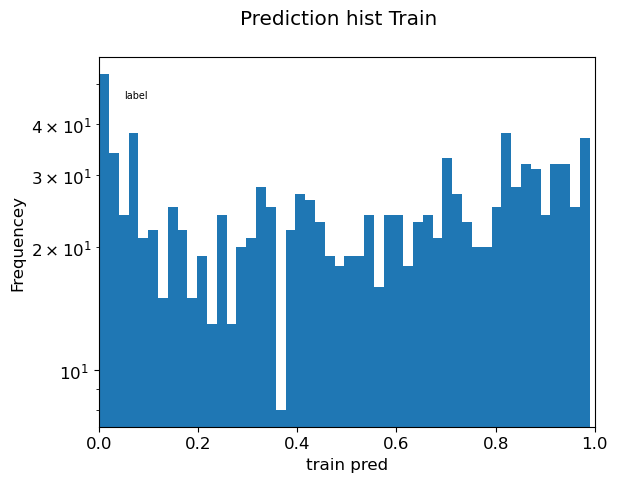

In [183]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

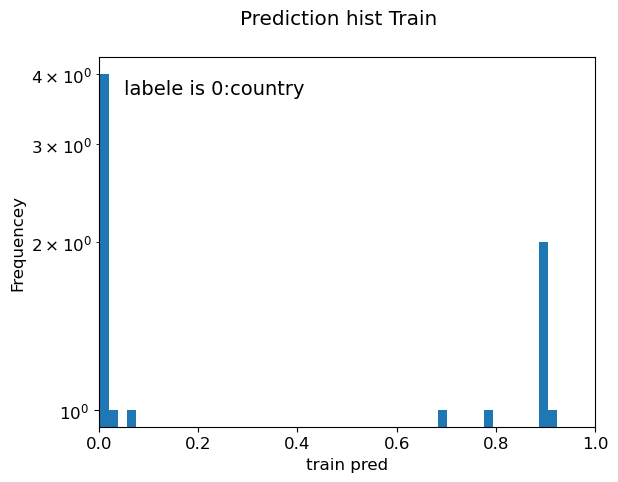

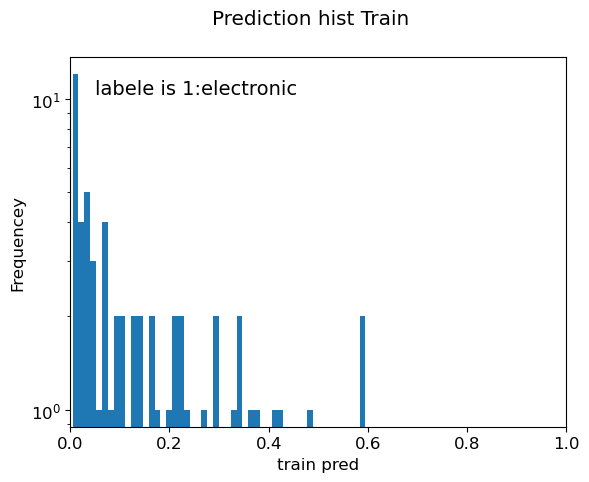

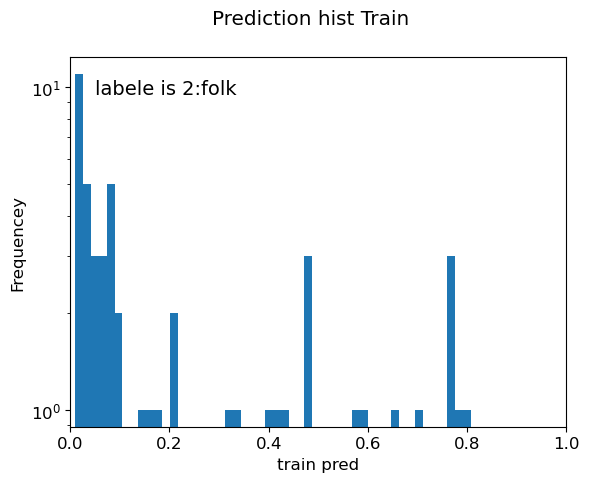

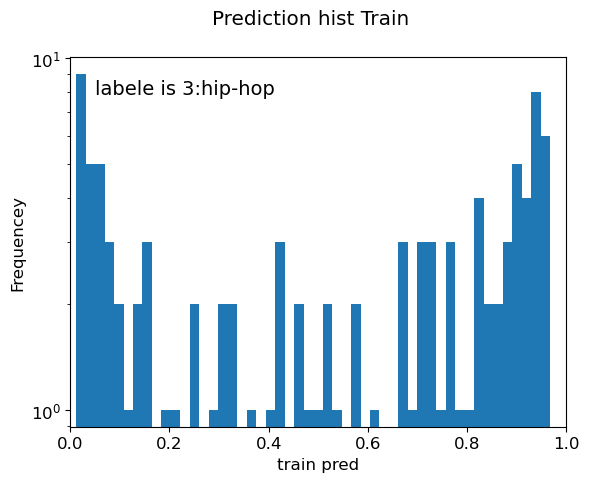

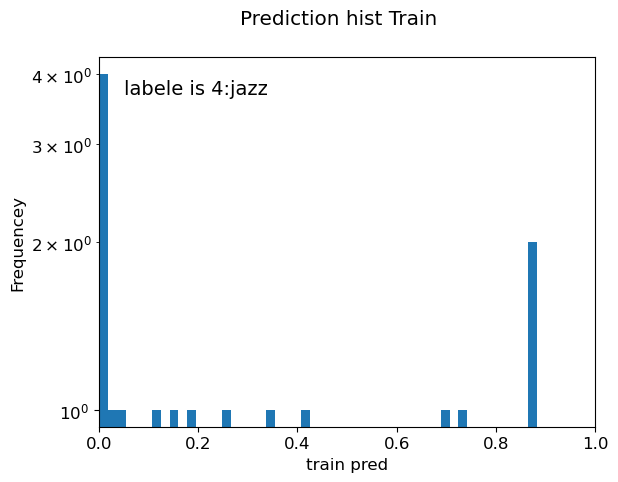

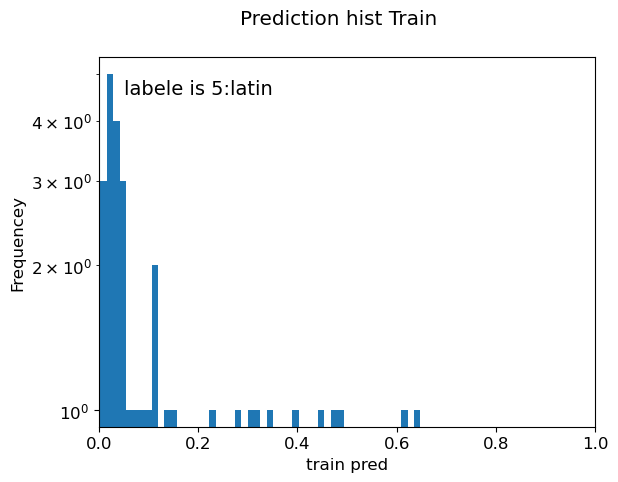

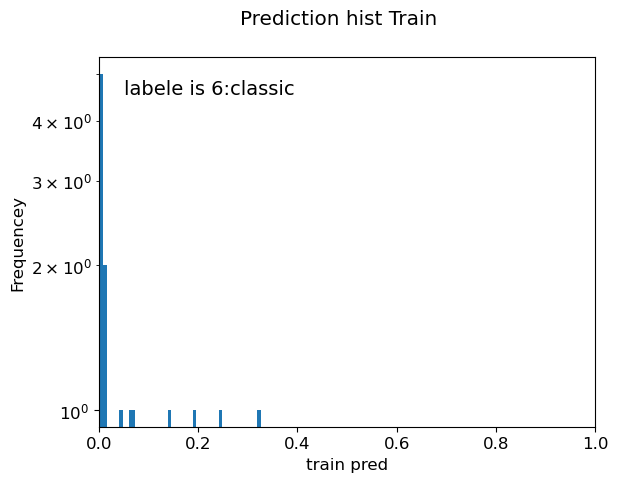

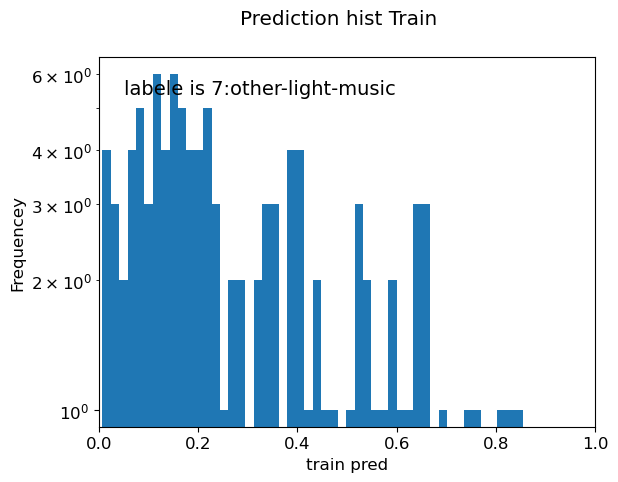

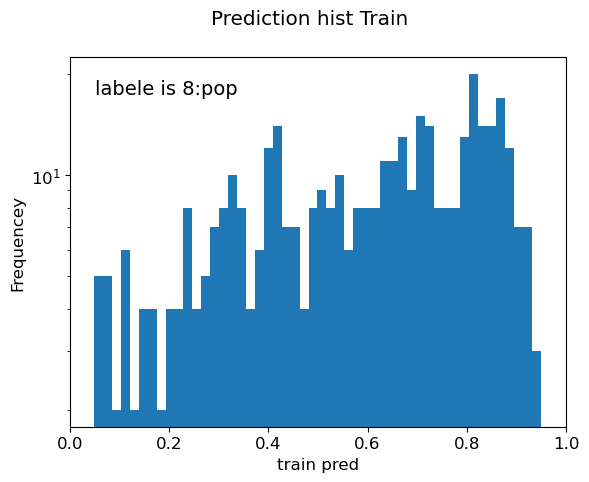

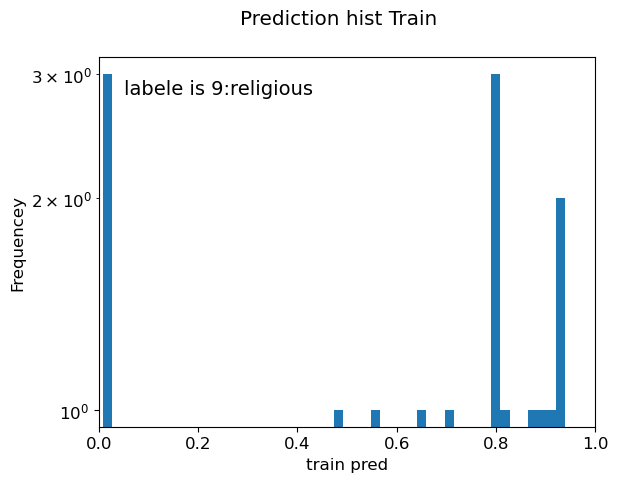

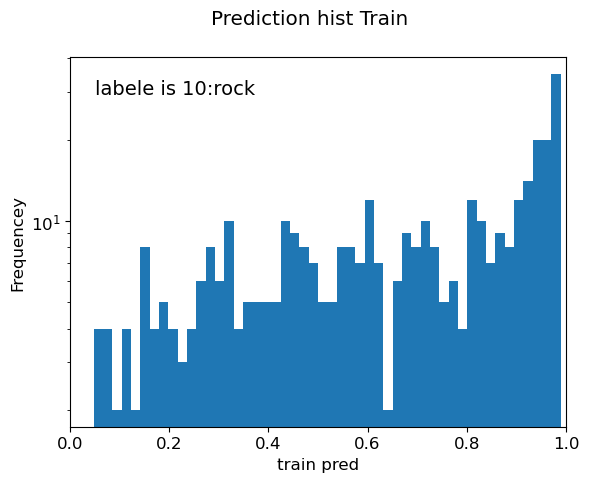

In [184]:
for i, y_pred_category in enumerate(y_pred_categorical):
    f, (ax) = plt.subplots()
    f.suptitle('Prediction hist Train')

    bins = 50

    ax.hist(y_pred_category, bins = bins)

    plt.xlabel('train pred')
    plt.ylabel('Frequencey')
    plt.xlim((0, 1))
    plt.yscale('log')
    plt.text(0.05, 0.9, 'labele is {}:{}'.format(i,genre_data["genre"][i]),transform = ax.transAxes, fontsize = 14)
    plt.show();

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

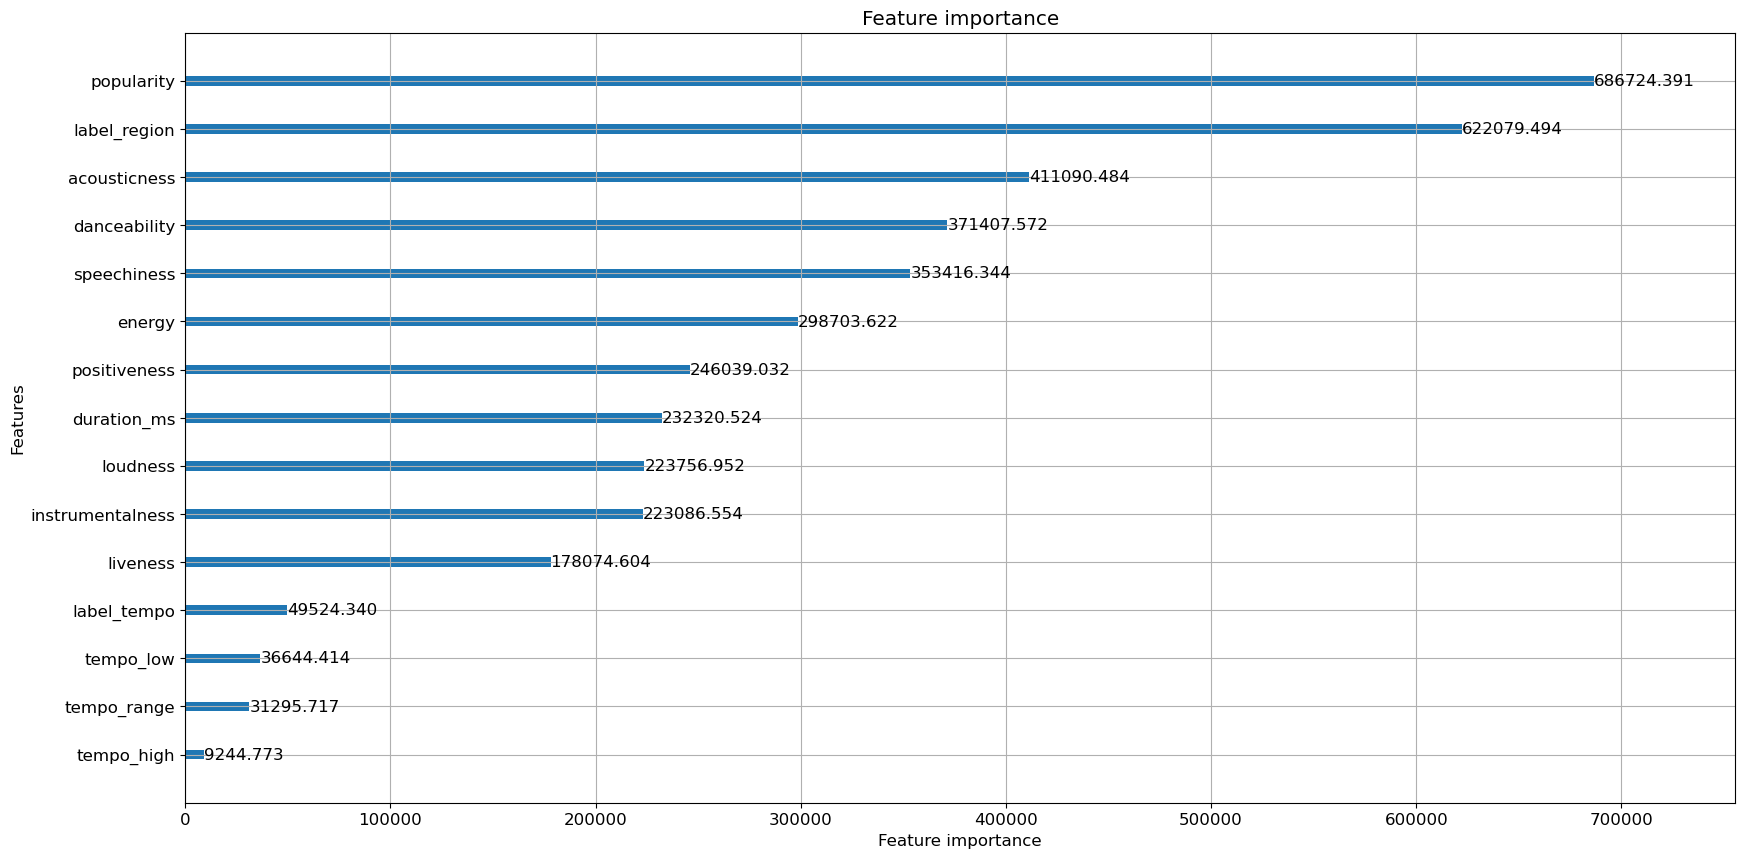

In [185]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

In [186]:
# ROCは２値分類からの変化点があるので一旦コメントアウトして進める。

# from sklearn import metrics
# import matplotlib.pyplot as plt
# fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_pred_train)
# auc = metrics.auc(fpr, tpr)
# print(auc)

# plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
# plt.plot(np.linspace(1, 0, len(fpr)), np.linspace(1, 0, len(fpr)), label='Random ROC curve (area = %.2f)'%0.5, linestyle = '--', color = 'gray')

# plt.legend()
# plt.title('ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.grid(True)
# plt.show()


f1_score=0.5815485996705108


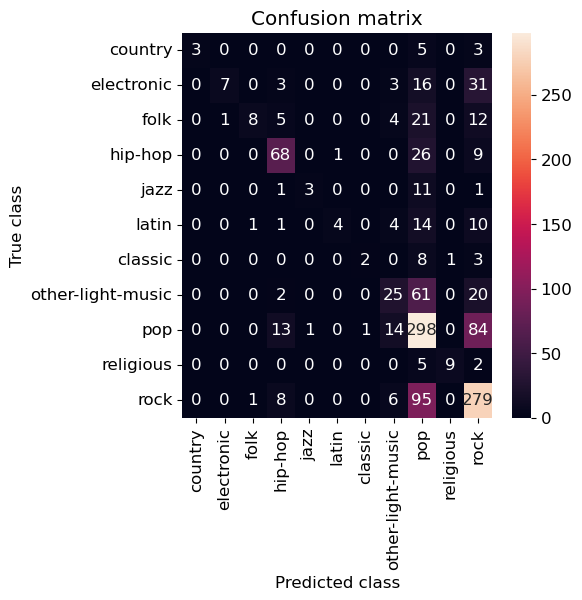

In [187]:
import os
import datetime
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


In [188]:
# PRカーブも２値分類からの変化点があるので一旦コメントアウト

# # y_pred = gbm.predict(test_total)
# precision, recall, thresholds = metrics.precision_recall_curve(y_valid, y_pred_train)

# auc = metrics.auc(recall, precision)
# print(auc)

# plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
# plt.legend()
# plt.title('PR curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.grid(True)
# plt.show()

In [189]:
# # ROC曲線を計算
# fpr, tpr, thresholds = roc_curve(y_valid, y_pred_train)
 
# # AUCを計算
# roc_auc = metrics.auc(fpr, tpr)
 
# # ROC曲線をプロット
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [190]:
# y_pred = np.where(y_pred >Dicision_threshould, 1, 0)
y_pred = y_pred.astype(int)
y_pred = pd.DataFrame(y_pred)
y_pred.head()

,1213
0,0
1,0
2,0
3,0
4,0


In [191]:
test_id.head()

0    4046
1    4047
2    4048
3    4049
4    4050
Name: index, dtype: int64

In [192]:
# make submission file
submission_pd = pd.concat([test_id, y_pred], axis=1)
submission_pd.head()
submission_pd.to_csv("submission.csv", index = False, header = False)


In [195]:
len(y_pred_train_rf)

1214

f1_score=0.5815485996705108


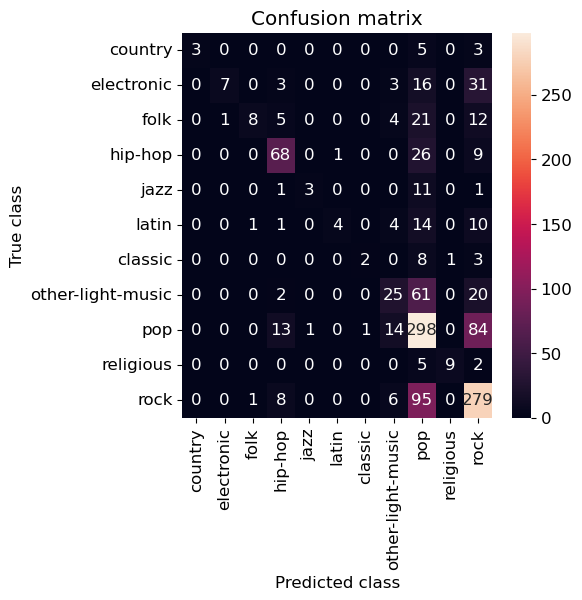

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [196]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train_ansamble > Dicision_threshould, 1, 0)
y_pred_int = y_pred_int.astype(int)

y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=genre_data["genre"], yticklabels=genre_data["genre"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

# make submission file
submission_pd = pd.concat([test_id, y_pred_train_ansamble], axis=1)
submission_pd.head()
submission_pd.to_csv("submission_ansamble.csv", index = False, header = False)